In [1]:
import glob
import numpy as np
import cv2
import csv
import pandas as pd
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from skimage.transform import resize

## Steuerungs-Parameter

In [2]:
#Parameter

#Speicherort der Test-Daten for example './GTSRB/Training'
TRAINING_DATA_PATH = "Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images" #"C:/Users/de136581/Documents/Uni/SoSe_2024/DSKI_Projekt/Data_trafic_Signs/Final_Training/GTSRB/Final_Training/Images" 

#Ist momentan nicht nötig
TEST_DATA_PATH = "Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Online-Test-Images/GTSRB/Online-Test/Images"

## Allgemeine Funktionen

In [3]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def format_imgs(imgs_lst):
    new_size = (32, 32)
    resized_images = []
    for img in imgs_lst:
        resized_img = resize(img, new_size, anti_aliasing=True)
        resized_images.append(resized_img)

    return np.array(resized_images)

In [4]:
# Mapper Funktion Klassennummer - Verkehrszeichen
def get_traffic_sign_name(class_id):
    # Dictionary that maps class IDs to traffic sign names in German
    class_id_to_name = {
        0: "Geschwindigkeitsbegrenzung (20km/h)",
        1: "Geschwindigkeitsbegrenzung (30km/h)",
        2: "Geschwindigkeitsbegrenzung (50km/h)",
        3: "Geschwindigkeitsbegrenzung (60km/h)",
        4: "Geschwindigkeitsbegrenzung (70km/h)",
        5: "Geschwindigkeitsbegrenzung (80km/h)",
        6: "Ende der Geschwindigkeitsbegrenzung (80km/h)",
        7: "Geschwindigkeitsbegrenzung (100km/h)",
        8: "Geschwindigkeitsbegrenzung (120km/h)",
        9: "Überholverbot",
        10: "Überholverbot für Fahrzeuge über 3,5 Tonnen",
        11: "Vorfahrt an der nächsten Kreuzung",
        12: "Vorfahrtstraße",
        13: "Vorfahrt gewähren",
        14: "Halt",
        15: "Verbot für Fahrzeuge",
        16: "Verbot für Fahrzeuge über 3,5 Tonnen",
        17: "Einfahrt verboten",
        18: "Allgemeine Gefahr",
        19: "Gefährliche Kurve nach links",
        20: "Gefährliche Kurve nach rechts",
        21: "Doppelkurve",
        22: "Unebene Fahrbahn",
        23: "Schleudergefahr bei Nässe oder Schmutz",
        24: "Fahrbahnverengung",
        25: "Baustelle",
        26: "Ampel",
        27: "Fußgänger",
        28: "Kinder",
        29: "Radfahrer",
        30: "Schnee- oder Eisglätte",
        31: "Wildwechsel",
        32: "Ende aller Streckenverbote",
        33: "Rechts abbiegen",
        34: "Links abbiegen",
        35: "Geradeaus",
        36: "Geradeaus oder rechts",
        37: "Geradeaus oder links",
        38: "Rechts vorbei",
        39: "Links vorbei",
        40: "Kreisverkehr",
        41: "Ende des Überholverbots",
        42: "Ende des Überholverbots für Fahrzeuge über 3,5 Tonnen"
    }
    
    # Return the name of the traffic sign corresponding to the given class ID
    return class_id_to_name.get(class_id, "Unbekannte Klassennummer")

### Dateneinlesen

für alle Klassifizierungen

In [5]:
# Trainings und Testdaten vorbereiten
trainImages, trainLabels =  readTrafficSigns(TRAINING_DATA_PATH)

## Binäre Klassifikation

Es soll nun zu Beginn ein Klassifikator gebaut werden, der Bilder des GTSRB-Datensatzes danach klassifiziert, ob diese zur Klasse 1 (Geschwindigkeitsbegrenzung (30km/h)) gehört.

Hierfür muss der Datensatz vorbereitet werden; Die Trainings- und Test-Daten müssen den neuen Klassen (true, false) bzw (1,0) zugeordnet werden. Anschließend müssen die Bilder noch die notwendigen Vorverarbeitungsschritte durchlaufen.

In [6]:
bin_labels = np.where( np.array(trainLabels) == 1, 1, 0)
# Train-Test-Aufteilung
bin_img_train, bin_img_test, bin_labels_train, bin_labels_test = train_test_split(trainImages,  bin_labels, test_size=0.2, random_state=42)

# Daten normalisieren
bin_img_train = format_imgs(bin_img_train) / 255
bin_img_test = format_imgs(bin_img_test) / 255

# Labels zu kategorischen Daten umwandeln
bin_labels_train = to_categorical(bin_labels_train, 2)
bin_labels_test = to_categorical(bin_labels_test, 2)

Erstellen eines CNN-Modell mit der Sequential API von Keras. 

Das Modell besteht aus:
- Zwei Convolutional-Schichten (Conv2D) mit ReLU-Aktivierung und Max-Pooling-Schichten (MaxPooling2D).
- Einer Flatten-Schicht (Flatten), um die 2D-Feature-Maps in einen 1D-Vektor umzuwandeln.
- Einer voll verbundenen Schicht (Dense) mit 128 Neuronen und einer Dropout-Schicht (Dropout), um Overfitting zu reduzieren.
- Einer Ausgabeschicht mit Softmax-Aktivierung, die für binäre Klassifikation geeignet ist.

Das Modell wird mit dem adam Optimierer kompiliert, der für schnelle Konvergenz bekannt ist. Die Verlustfunktion binary_crossentropy wird für die binäre Klassifikation verwendet, und die Metrik accuracy wird zur Bewertung des Modells genutzt.

Anschließend wird das Modell mit den Trainingsdaten 'bin_img_train' und 'bin_labels_train' trainiert. Das Training erfolgt über 10 Epochen mit einer Batch-Größe von 32. Die Validierungsdaten bin_img_test und bin_labels_test werden verwendet, um die Leistung des Modells während des Trainings zu überwachen.

In [7]:
# CNN-Modell erstellen
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),   # Faltungsschicht mit 32 Filtern, 3x3 Kernel, ReLU-Aktivierung, Eingabeform (32, 32, 3)
    MaxPooling2D((2, 2)),                                             # Max-Pooling-Schicht mit 2x2 Pooling-Fenster
    Conv2D(64, (3, 3), activation='relu'),                            # Weitere Faltungsschicht mit 64 Filtern, 3x3 Kernel, ReLU-Aktivierung
    MaxPooling2D((2, 2)),                                             # Weitere Max-Pooling-Schicht mit 2x2 Pooling-Fenster
    Flatten(),                                                        # Umwandeln der 2D-Feature-Maps in 1D-Feature-Vektor
    Dense(128, activation='relu'),                                    # Voll verbundene Schicht (Dense Layer) mit 128 Neuronen und ReLU-Aktivierung
    Dropout(0.5),                                                     # Dropout-Schicht zur Reduktion von Overfitting, 50% Dropout-Rate
    Dense(2, activation='softmax')                                    # Ausgabeschicht mit 2 Neuronen und Softmax-Aktivierung für binäre Klassifikation
])


# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell trainieren
bin_history = model.fit(bin_img_train, bin_labels_train, epochs=10, validation_data=(bin_img_test, bin_labels_test), batch_size=32)

c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9986 - loss: 0.0395 - val_accuracy: 1.0000 - val_loss: 6.0100e-11
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 1.0000 - loss: 7.4874e-07 - val_accuracy: 1.0000 - val_loss: 9.4353e-13
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 1.0000 - loss: 1.2486e-07 - val_accuracy: 1.0000 - val_loss: 2.0709e-13
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 1.0000 - loss: 1.5664e-07 - val_accuracy: 1.0000 - val_loss: 3.0644e-14
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 1.0000 - loss: 5.1542e-06 - val_accuracy: 1.0000 - val_loss: 3.1328e-15
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 1.0000 - loss: 4.2448e-08 - val_accuracy: 1.0000 - val_loss: 1.0692e-15
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 1.0000 - loss: 1.1929e-08 - val_accuracy: 1.0000 - val_loss: 3.0111e-16
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━

### Gütemaß Genauigkeit (Accuracy) vs. Verlust (Loss)

In diesem Code werden verschiedene Gütemaße verwendet, um die Leistung des CNN-Modells zu bewerten. Diese Maße sind besonders wichtig, um zu verstehen, wie gut das Modell arbeitet und wo möglicherweise Verbesserungen notwendig sind. Die wichtigsten Gütemaße in diesem Kontext sind die Genauigkeit (Accuracy) und der Verlust (Loss).


#### Genauigkeit (Accuracy)
Die Genauigkeit ist ein Maß dafür, wie viele der Vorhersagen des Modells korrekt sind. Sie wird berechnet als der Anteil der korrekt klassifizierten Beispiele an der Gesamtzahl der Beispiele. Für binäre Klassifikation, wie in diesem Fall, kann die Genauigkeit folgendermaßen berechnet werden:

$Genauigkeit = \frac{Anzahl der korrekten Vorhersagen}{Gesamtzahl der Vorhersagen}$

##### Bedeutung:
- Hohe Genauigkeit: Das Modell trifft in den meisten Fällen die richtige Entscheidung.
- Niedrige Genauigkeit: Das Modell macht viele Fehler und muss möglicherweise verbessert werden.



#### Verlust (Loss)
Der Verlust ist ein Maß dafür, wie schlecht das Modell während des Trainings abschneidet. Es handelt sich dabei um eine Funktion, die den Unterschied zwischen den tatsächlichen Labels und den vom Modell vorhergesagten Wahrscheinlichkeiten misst. In diesem Code wird der binary_crossentropy-Verlust verwendet.

##### Bedeutung:
- Niedriger Verlust: Die Vorhersagen des Modells sind näher an den tatsächlichen Labels, was ein Zeichen für ein gut funktionierendes Modell ist.
- Hoher Verlust: Die Vorhersagen des Modells weichen stark von den tatsächlichen Labels ab, was auf ein schlecht funktionierendes Modell hindeutet.



#### Trainingsgenauigkeit vs. Validierungsgenauigkeit
Trainingsgenauigkeit: Dies ist die Genauigkeit, die das Modell auf den Trainingsdaten erreicht. Sie gibt an, wie gut das Modell die Trainingsdaten gelernt hat.
Validierungsgenauigkeit: Dies ist die Genauigkeit, die das Modell auf den Validierungsdaten erreicht. Sie gibt an, wie gut das Modell auf unbekannten Daten generalisiert.

##### Bedeutung der Unterscheidung:
- Hohe Trainingsgenauigkeit, aber niedrige Validierungsgenauigkeit: Dies deutet auf Overfitting hin, was bedeutet, dass das Modell die Trainingsdaten gut gelernt hat, aber Schwierigkeiten hat, auf neuen, unbekannten Daten gut zu generalisieren.
- Ähnliche Trainings- und Validierungsgenauigkeit: Dies deutet darauf hin, dass das Modell sowohl auf den Trainingsdaten als auch auf den Validierungsdaten gut funktioniert und wahrscheinlich gut generalisiert.

Trainingsverlust vs. Validierungsverlust
Trainingsverlust: Dies ist der Verlust, den das Modell auf den Trainingsdaten hat. Ein niedriger Trainingsverlust zeigt, dass das Modell die Trainingsdaten gut gelernt hat.
Validierungsverlust: Dies ist der Verlust, den das Modell auf den Validierungsdaten hat. Ein niedriger Validierungsverlust zeigt, dass das Modell gut auf unbekannten Daten funktioniert.
Bedeutung der Unterscheidung:
Hoher Trainingsverlust: Das Modell hat Schwierigkeiten, die Trainingsdaten zu lernen.
Hoher Validierungsverlust: Das Modell generalisiert nicht gut auf neue Daten.
Insgesamt sind Genauigkeit und Verlust zwei der am häufigsten verwendeten Gütemaße zur Bewertung von Modellen, da sie ein umfassendes Bild davon geben, wie gut das Modell funktioniert. Hohe Genauigkeit und niedriger Verlust sowohl beim Training als auch bei der Validierung sind Anzeichen für ein gut funktionierendes Modell.

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.9402e-18
Validation accuracy: 1.0


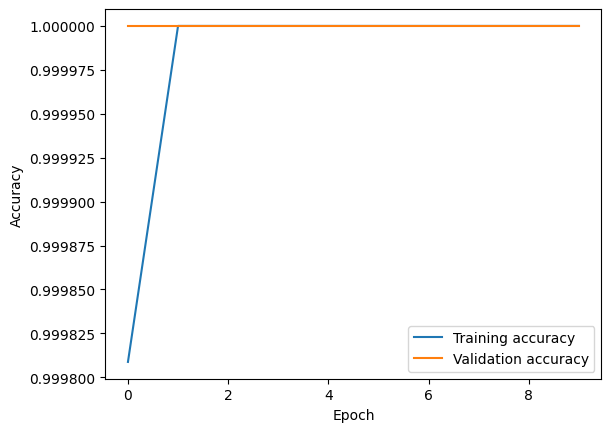

In [8]:
# Modellbewertung
val_loss, val_acc = model.evaluate(bin_img_test, bin_labels_test)
print(f'Validation accuracy: {val_acc}')

plt.plot(bin_history.history['accuracy'], label='Training accuracy')
plt.plot(bin_history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## CNN Multiclass
Im Folgenden soll ein Convolutional Neural Network (CNN) für die Multiklassen-Klassifikation von Verkehrszeichen trainiert und bewertet werden

### Datenaufbereitung und Preprocessing

In [9]:
# Train-Test-Aufteilung / wobei 20% der Daten für das Testset verwendet werden. Die random_state=42 sorgt dafür, dass die Aufteilung reproduzierbar ist.
img_train, img_test, labels_train, labels_test = train_test_split(trainImages,  trainLabels, test_size=0.2, random_state=42)

# One-Hot-Encoding der Labels
# Die Labels werden in One-Hot-Vektoren umgewandelt, um sie für die Multiklassen-Klassifikation vorzubereiten. Es gibt 43 Klassen für die verschiedenen Verkehrszeichen.
labels_train = to_categorical(labels_train, 43)
labels_test = to_categorical(labels_test, 43)

#Bilder formatieren, damit sie in das Modell eingespeist werden können
img_train = format_imgs(img_train)
img_test = format_imgs(img_test)

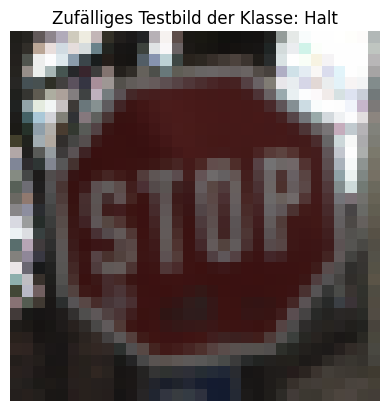

In [10]:
# Demonstration des Datensatzes:
# Wähle ein zufälliges Bild aus dem Trainingsdatensatz 
random_index = np.random.randint(0, len(img_train))
bsp_image = img_train[random_index]
bsp_label = labels_train[random_index]

# Zeige das Bild an
plt.imshow(bsp_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild der Klasse: {get_traffic_sign_name(np.argmax(bsp_label))}")
plt.axis('off')
plt.show()

### Erstellen des Modells
Erstellen eines CNN-Modell mit der Sequential API von Keras. 

Es besteht aus:

- Einer Convolutional-Schicht (Conv2D) mit ReLU-Aktivierung und einer Max-Pooling-Schicht (MaxPooling2D).
- Einer Flatten-Schicht (Flatten), um die 2D-Feature-Maps in einen 1D-Vektor umzuwandeln.
- Einer voll verbundenen Schicht (Dense) mit 128 Neuronen und einer weiteren Dense-Schicht mit 43 Neuronen und Softmax-Aktivierung für die 43 Klassen.

Anschließend wird das Modell mit dem adam Optimierer kompiliert, der für schnelle Konvergenz bekannt ist. Die Metrik accuracy wird zur Bewertung des Modells genutzt.

In [11]:
# Modellarchitektur
# Definiere das Modell
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))   # Faltungsschicht mit 32 Filtern, 3x3 Kernel, ReLU-Aktivierung, Eingabeform (32, 32, 3)
model.add(layers.MaxPooling2D((2, 2)))                                             # Max-Pooling-Schicht mit 2x2 Pooling-Fenster
model.add(layers.Flatten())                                                        # Umwandeln der 2D-Feature-Maps in 1D-Feature-Vektor
model.add(layers.Dense(128, activation='relu'))                                    # Voll verbundene Schicht (Dense Layer) mit 128 Neuronen und ReLU-Aktivierung
model.add(layers.Dense(43, activation='softmax'))                                  # Ausgabeschicht mit 43 Neuronen und Softmax-Aktivierung für Multiklassen-Klassifikation


# Kompiliere das Modell
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(img_train, labels_train, epochs=10, batch_size=32, validation_data=(img_test, labels_test)) #, validation_data=(img_test, labels_test)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5698 - loss: 1.7018 - val_accuracy: 0.9277 - val_loss: 0.2949
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9461 - loss: 0.2193 - val_accuracy: 0.9582 - val_loss: 0.1587
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9719 - loss: 0.1154 - val_accuracy: 0.9705 - val_loss: 0.1233
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9802 - loss: 0.0842 - val_accuracy: 0.9602 - val_loss: 0.1485
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9855 - loss: 0.0594 - val_accuracy: 0.9721 - val_loss: 0.1217
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9901 - loss: 0.0381 - val_accuracy: 0.9672 - val_loss: 0.1311
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9893 - loss: 0.0391 - val_accuracy: 0.9759 - val_loss: 0.1042
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9904 - loss: 0.0315 - 

### Modell-Evaluation

Im Folgenden soll unser erstelltes Modell evaluiert werden. Wir wollen also bestimmen, wie gut unser Trainiertes Modell Bilder des Test-Datensatzes erkennt.

Dazu betrachten wir einmal ein zufällig ausgewähltes Bild und die vom Modell vorhergesagte Klasse:


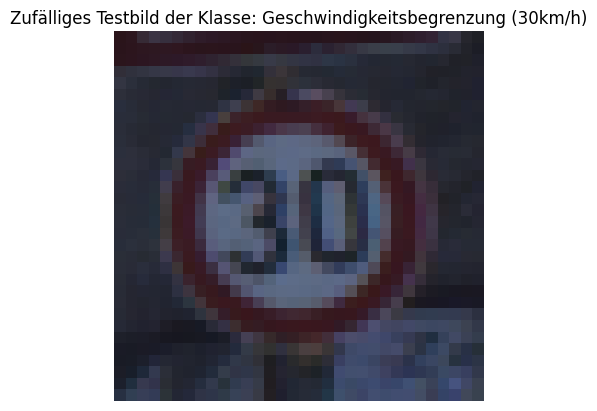

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Vorhergesagte Klasse: Geschwindigkeitsbegrenzung (30km/h)
Wahrscheinlichkeit: 1.00


In [13]:
#Testen des Modells:
    
# Wähle ein zufälliges Bild aus dem Testdatensatz
random_index = np.random.randint(0, len(img_test))
test_image = img_test[random_index]
true_label = labels_test[random_index]

# Zeige das Bild an
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild der Klasse: {get_traffic_sign_name(np.argmax(true_label))}")
plt.axis('off')
plt.show()

# Klassifiziere das Bild mit dem trainierten Modell
predicted_probs = model.predict(np.expand_dims(test_image, axis=0))
predicted_class = np.argmax(predicted_probs)

# Gib die Klassifizierung und die Wahrscheinlichkeit aus
print(f"Vorhergesagte Klasse: {get_traffic_sign_name(np.argmax(true_label))}")
print(f"Wahrscheinlichkeit: {predicted_probs[0][predicted_class]:.2f}")

Hier wird das trainierte Modell anhand der Testdaten bewertet. Der Validierungsverlust (val_loss) und die Validierungsgenauigkeit (val_acc) werden wie oben erläutert berechnet

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9701 - loss: 0.1300
Validation accuracy: 0.9718183875083923


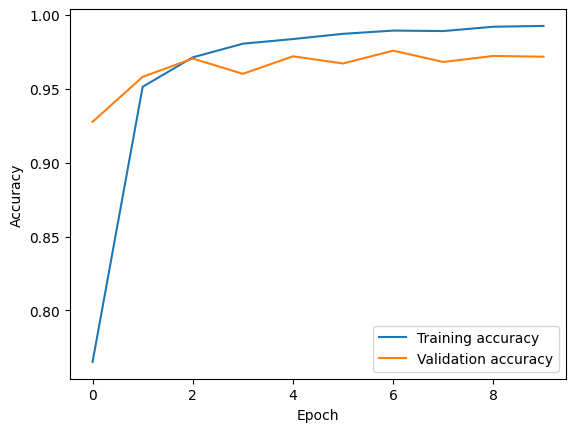

In [14]:
# Modellbewertung
val_loss, val_acc = model.evaluate(img_test, labels_test)
print(f'Validation accuracy: {val_acc}')

# Plotten der Trainingsgeschichte
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Gütemaße

In [15]:
# Vorhersagen für die Testdaten
y_pred = model.predict(img_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Für die Bewertung von Modellen zur Multiklassen-Klassifikation, wie in dem gegebenen Beispiel, sind verschiedene Gütemaße relevant. Zu den wichtigsten gehören **Accuracy (Genauigkeit)**, **Precision (Präzision)**, **Recall (Sensitivität)** und **F1-Score**. Diese Metriken bieten verschiedene Perspektiven auf die Leistung des Modells und helfen dabei, Stärken und Schwächen in der Klassifikation zu identifizieren.

#### 1. Accuracy (Genauigkeit)
Die Accuracy gibt den Anteil der korrekt klassifizierten Instanzen an der Gesamtzahl der Instanzen an. Für Multiklassen-Klassifikation wird sie wie folgt berechnet:

$ \text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}\left( y_i = \hat{y}_i \right) $



wobei:
- $N$ die Gesamtzahl der Instanzen ist,
- $y_i$ das wahre Label der $i$-ten Instanz ist,
- $ \hat{y}_i $ das vorhergesagte Label der $i$-ten Instanz ist,
- $ \mathbb{1} $ eine Indikatorfunktion ist, die 1 ist, wenn die Bedingung wahr ist, und 0, wenn sie falsch ist.

#### 2. Precision (Präzision)
Precision misst den Anteil der korrekt klassifizierten positiven Instanzen an allen Instanzen, die als positiv klassifiziert wurden. Für eine Klasse $ k $ in der Multiklassen-Klassifikation wird die Präzision wie folgt berechnet:

$ \text{Precision}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k} $



wobei:
- $ \text{TP}_k $ die Anzahl der True Positives für Klasse $ k $ ist,
- $ \text{FP}_k $ die Anzahl der False Positives für Klasse $ k $ ist.

#### 3. Recall (Sensitivität)
Recall misst den Anteil der korrekt klassifizierten positiven Instanzen an allen tatsächlich positiven Instanzen. Für eine Klasse $ k $ wird der Recall wie folgt berechnet:

$ \text{Recall}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k} $

wobei:
- $ \text{TP}_k $ die Anzahl der True Positives für Klasse $ k $ ist,
- $ \text{FN}_k $ die Anzahl der False Negatives für Klasse $ k $ ist.

#### 4. F1-Score
Der F1-Score ist das harmonische Mittel von Precision und Recall. Er bietet eine Balance zwischen Precision und Recall und wird wie folgt berechnet:

$ \text{F1-Score}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k} $

In LaTeX-Schreibweise:

$ \text{F1-Score}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k} $

#### Vergleich zwischen Multiklassen- und Binärer Klassifikation
In der binären Klassifikation gibt es nur zwei Klassen, häufig als positiv und negativ bezeichnet. Die Berechnungen für Precision, Recall und F1-Score sind daher einfacher und beziehen sich auf eine positive Klasse.

Für Multiklassen-Klassifikation wird jede Klasse als "positiv" betrachtet, während alle anderen Klassen als "negativ" betrachtet werden. Dies führt zu individuellen Precision-, Recall- und F1-Score-Werten für jede Klasse. Zur Gesamtevaluierung können diese Metriken auf zwei Weisen aggregiert werden:

1. **Mikro-Mittelwert**: Betrachtet alle Klassen als gleich und summiert die einzelnen True Positives, False Positives und False Negatives über alle Klassen hinweg, bevor die Metriken berechnet werden.

   In LaTeX-Schreibweise für Precision:

   $ \text{Precision}_{\text{micro}} = \frac{\sum_{k} \text{TP}_k}{\sum_{k} (\text{TP}_k + \text{FP}_k)} $

2. **Makro-Mittelwert**: Berechnet die Metriken für jede Klasse und nimmt dann den Durchschnitt dieser Metriken. Jede Klasse wird gleich gewichtet, unabhängig von ihrer Größe.

   In LaTeX-Schreibweise für Precision:

   $ \text{Precision}_{\text{macro}} = \frac{1}{K} \sum_{k=1}^{K} \text{Precision}_k $

   wobei $ K $ die Anzahl der Klassen ist.

#### Zusammenfassung
- **Accuracy**: Gesamte korrekte Vorhersagen. Für binäre und Multiklassen-Klassifikation identisch berechnet.
- **Precision**: Fokus auf die Qualität der positiven Vorhersagen. In der Multiklassen-Klassifikation für jede Klasse separat berechnet.
- **Recall**: Fokus auf die Erfassung der tatsächlichen positiven Instanzen. In der Multiklassen-Klassifikation für jede Klasse separat berechnet.
- **F1-Score**: Balance zwischen Precision und Recall. In der Multiklassen-Klassifikation für jede Klasse separat berechnet.

Durch die Verwendung dieser Gütemaße kann ein umfassendes Bild der Modellleistung gewonnen werden, was für die Verbesserung und Feinabstimmung von Modellen in der Praxis unerlässlich ist.

In [16]:
# Metriken ausgeben
report = classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(43)])
print(report)

# Gütemaße für das gesamte Modell berechnen und ausgeben
accuracy = accuracy_score(y_true, y_pred_classes)
macro_precision = precision_score(y_true, y_pred_classes, average='macro')
macro_recall = recall_score(y_true, y_pred_classes, average='macro')
macro_f1 = f1_score(y_true, y_pred_classes, average='macro')
weighted_precision = precision_score(y_true, y_pred_classes, average='weighted')
weighted_recall = recall_score(y_true, y_pred_classes, average='weighted')
weighted_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Macro-Averaged Precision: {macro_precision:.4f}')
print(f'Macro-Averaged Recall: {macro_recall:.4f}')
print(f'Macro-Averaged F1 Score: {macro_f1:.4f}')
print(f'Weighted-Averaged Precision: {weighted_precision:.4f}')
print(f'Weighted-Averaged Recall: {weighted_recall:.4f}')
print(f'Weighted-Averaged F1 Score: {weighted_f1:.4f}')

              precision    recall  f1-score   support

     Class 0       0.97      0.92      0.95        38
     Class 1       0.97      0.98      0.98       496
     Class 2       0.97      0.97      0.97       450
     Class 3       0.88      0.99      0.93       280
     Class 4       1.00      0.99      0.99       418
     Class 5       0.98      0.89      0.93       364
     Class 6       1.00      1.00      1.00        59
     Class 7       1.00      0.93      0.96       278
     Class 8       0.93      0.99      0.96       301
     Class 9       0.95      0.99      0.97       268
    Class 10       0.98      0.99      0.98       370
    Class 11       1.00      0.99      0.99       236
    Class 12       1.00      1.00      1.00       450
    Class 13       1.00      0.96      0.98       452
    Class 14       1.00      0.99      0.99       162
    Class 15       0.92      1.00      0.96       120
    Class 16       1.00      1.00      1.00        90
    Class 17       1.00    

### Confusion Matrix
Eine **Konfusionsmatrix** (Oft auch Wahrheitsmatrix genannt) ist ein weiteres grundlegendes Werkzeug zur Bewertung der Leistung eines Klassifikationsmodells. Sie zeigt auf, wie oft das Modell jede Klasse korrekt oder falsch vorhergesagt hat und ermöglicht es, die Leistung in einer strukturierten und übersichtlichen Form zu analysieren.

### Aufbau einer Konfusionsmatrix

Für eine Klassifikation mit $N$ Klassen ist die Konfusionsmatrix eine $N \times N$ Matrix, in der:

- Die Zeilen die tatsächlichen Klassen repräsentieren.
- Die Spalten die vorhergesagten Klassen repräsentieren.

Jede Zelle $M[i, j]$ in der Matrix gibt die Anzahl der Beobachtungen an, die zur tatsächlichen Klasse $i$ gehören und als Klasse $j$ vorhergesagt wurden.

### Beispiel einer Konfusionsmatrix

Für eine binäre Klassifikation kann die Konfusionsmatrix wie folgt aussehen:


\begin{array}{c|cc}
\text{Aktuelle Klasse} & \text{Vorhergesagte Klasse Positiv} & \text{Vorhergesagte Klasse Negativ} \\
\hline
\text{Positiv} & \text{TP} & \text{FN} \\
\text{Negativ} & \text{FP} & \text{TN}
\end{array}


Für eine Multiklassen-Klassifikation, z.B. mit drei Klassen, könnte die Matrix so aussehen:


\begin{array}{c|ccc}
\text{Aktuelle Klasse} & \text{Vorhergesagte Klasse A} & \text{Vorhergesagte Klasse B} & \text{Vorhergesagte Klasse C} \\
\hline
\text{A} & 50 & 2 & 1 \\
\text{B} & 10 & 40 & 5 \\
\text{C} & 0 & 3 & 47 \\
\end{array}


### Berechnung und Interpretation

Die Berechnung der Konfusionsmatrix erfolgt durch Vergleich der tatsächlichen Klassen mit den vorhergesagten Klassen für jede Instanz im Datensatz. Aus der Konfusionsmatrix lassen sich die eben erklärten Leistungskennzahlen berechnen:
- **Accuracy**: Gesamtgenauigkeit des Modells.
- **Precision (Präzision)**: Wie viele der als positiv klassifizierten Instanzen tatsächlich positiv sind.
- **Recall (Sensitivität)**: Wie viele der tatsächlichen positiven Instanzen korrekt klassifiziert wurden.
- **F1-Score**: Harmonisches Mittel von Precision und Recall.

Diese Metriken werden hier wie folgt berechnet:

$
\text{Accuracy} = \frac{\sum_{i} M[i, i]}{\sum_{i} \sum_{j} M[i, j]}
$

$
\text{Precision}_k = \frac{M[k, k]}{\sum_{i} M[i, k]}
$

$
\text{Recall}_k = \frac{M[k, k]}{\sum_{j} M[k, j]}
$

$
\text{F1-Score}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
$

### Anwendung der Konfusionsmatrix

Die Konfusionsmatrix hilft dabei, die Leistung eines Modells detailliert zu analysieren. Sie zeigt an, welche Klassen häufig miteinander verwechselt werden, und gibt Hinweise darauf, wo das Modell verbessert werden könnte. Beispielsweise können systematische Fehler identifiziert und gezielt Maßnahmen ergriffen werden, um die Klassifikationsgenauigkeit zu erhöhen.

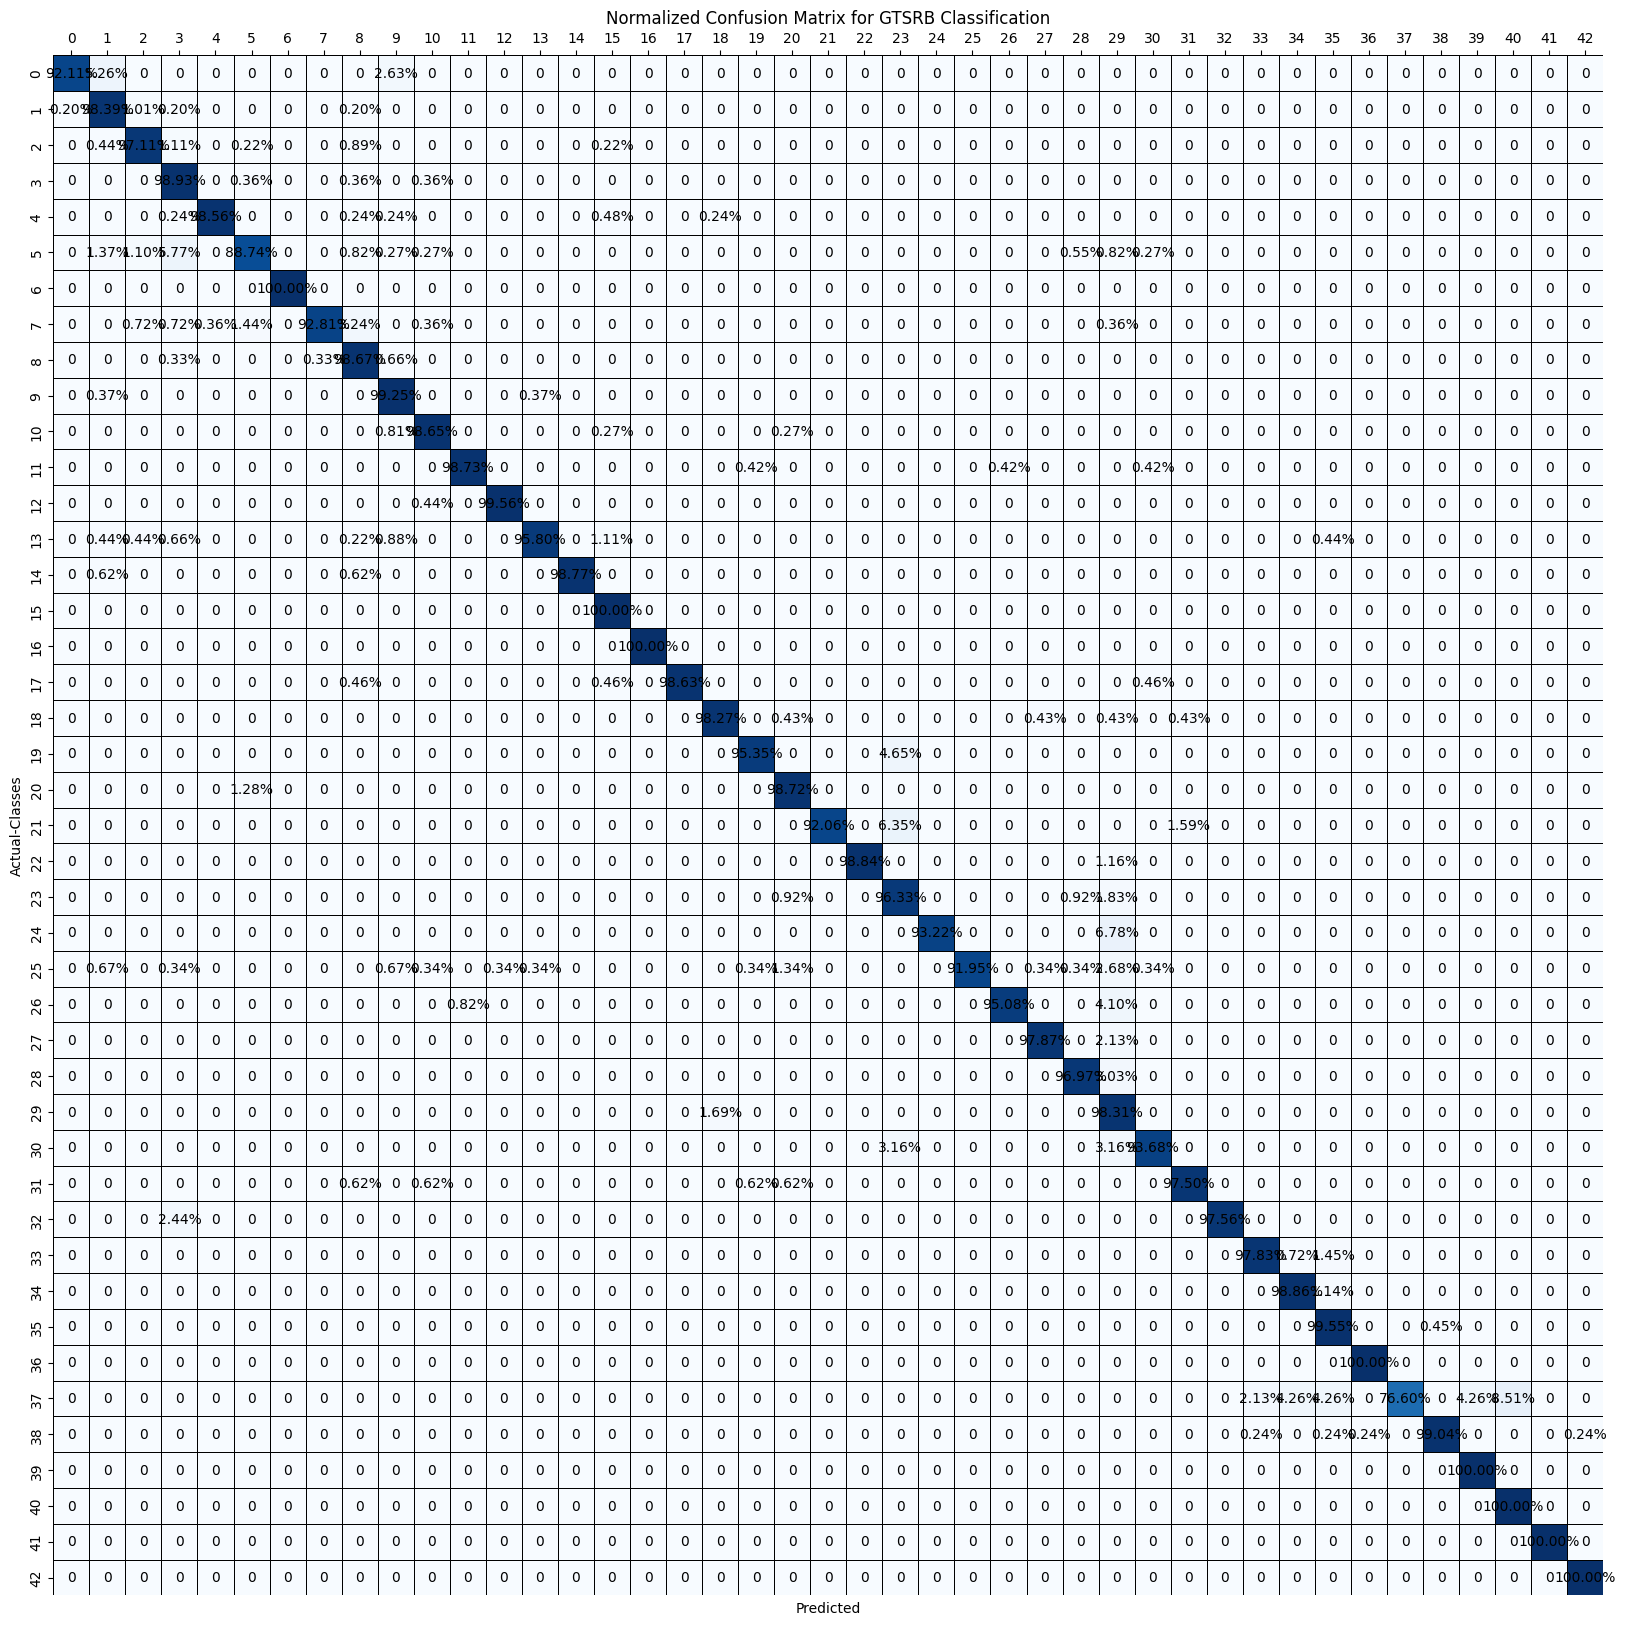

In [17]:
# Confusion Matrix berechnen
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix normalisieren
# die Matrix wird normalisiert, um Anteile anstelle von absoluten Werten anzuzeigen.
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Replace NaNs with 0

# Funktion zum Formatieren der Werte
def format_func(value):
    if value == 0:
        return '0'
    elif value < 0.0001:  # Wert < 0.01%
        return ''
    else:
        return f'{value:.2%}'

# Confusion Matrix visualisieren
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_normalized, fmt='', cmap='Blues', xticklabels=range(43), yticklabels=range(43),
            annot_kws={"size": 7}, cbar=False, linewidths=.5, linecolor='black')

# Set custom annotations
for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        plt.text(j + 0.5, i + 0.5, format_func(conf_matrix_normalized[i, j]),
                 horizontalalignment='center', verticalalignment='center')

plt.xlabel('Predicted')

# X-Achse am oberen Rand platzieren
plt.gca().xaxis.set_ticks_position('top')
plt.ylabel('Actual-Classes')
plt.title('Normalized Confusion Matrix for GTSRB Classification')
plt.show()

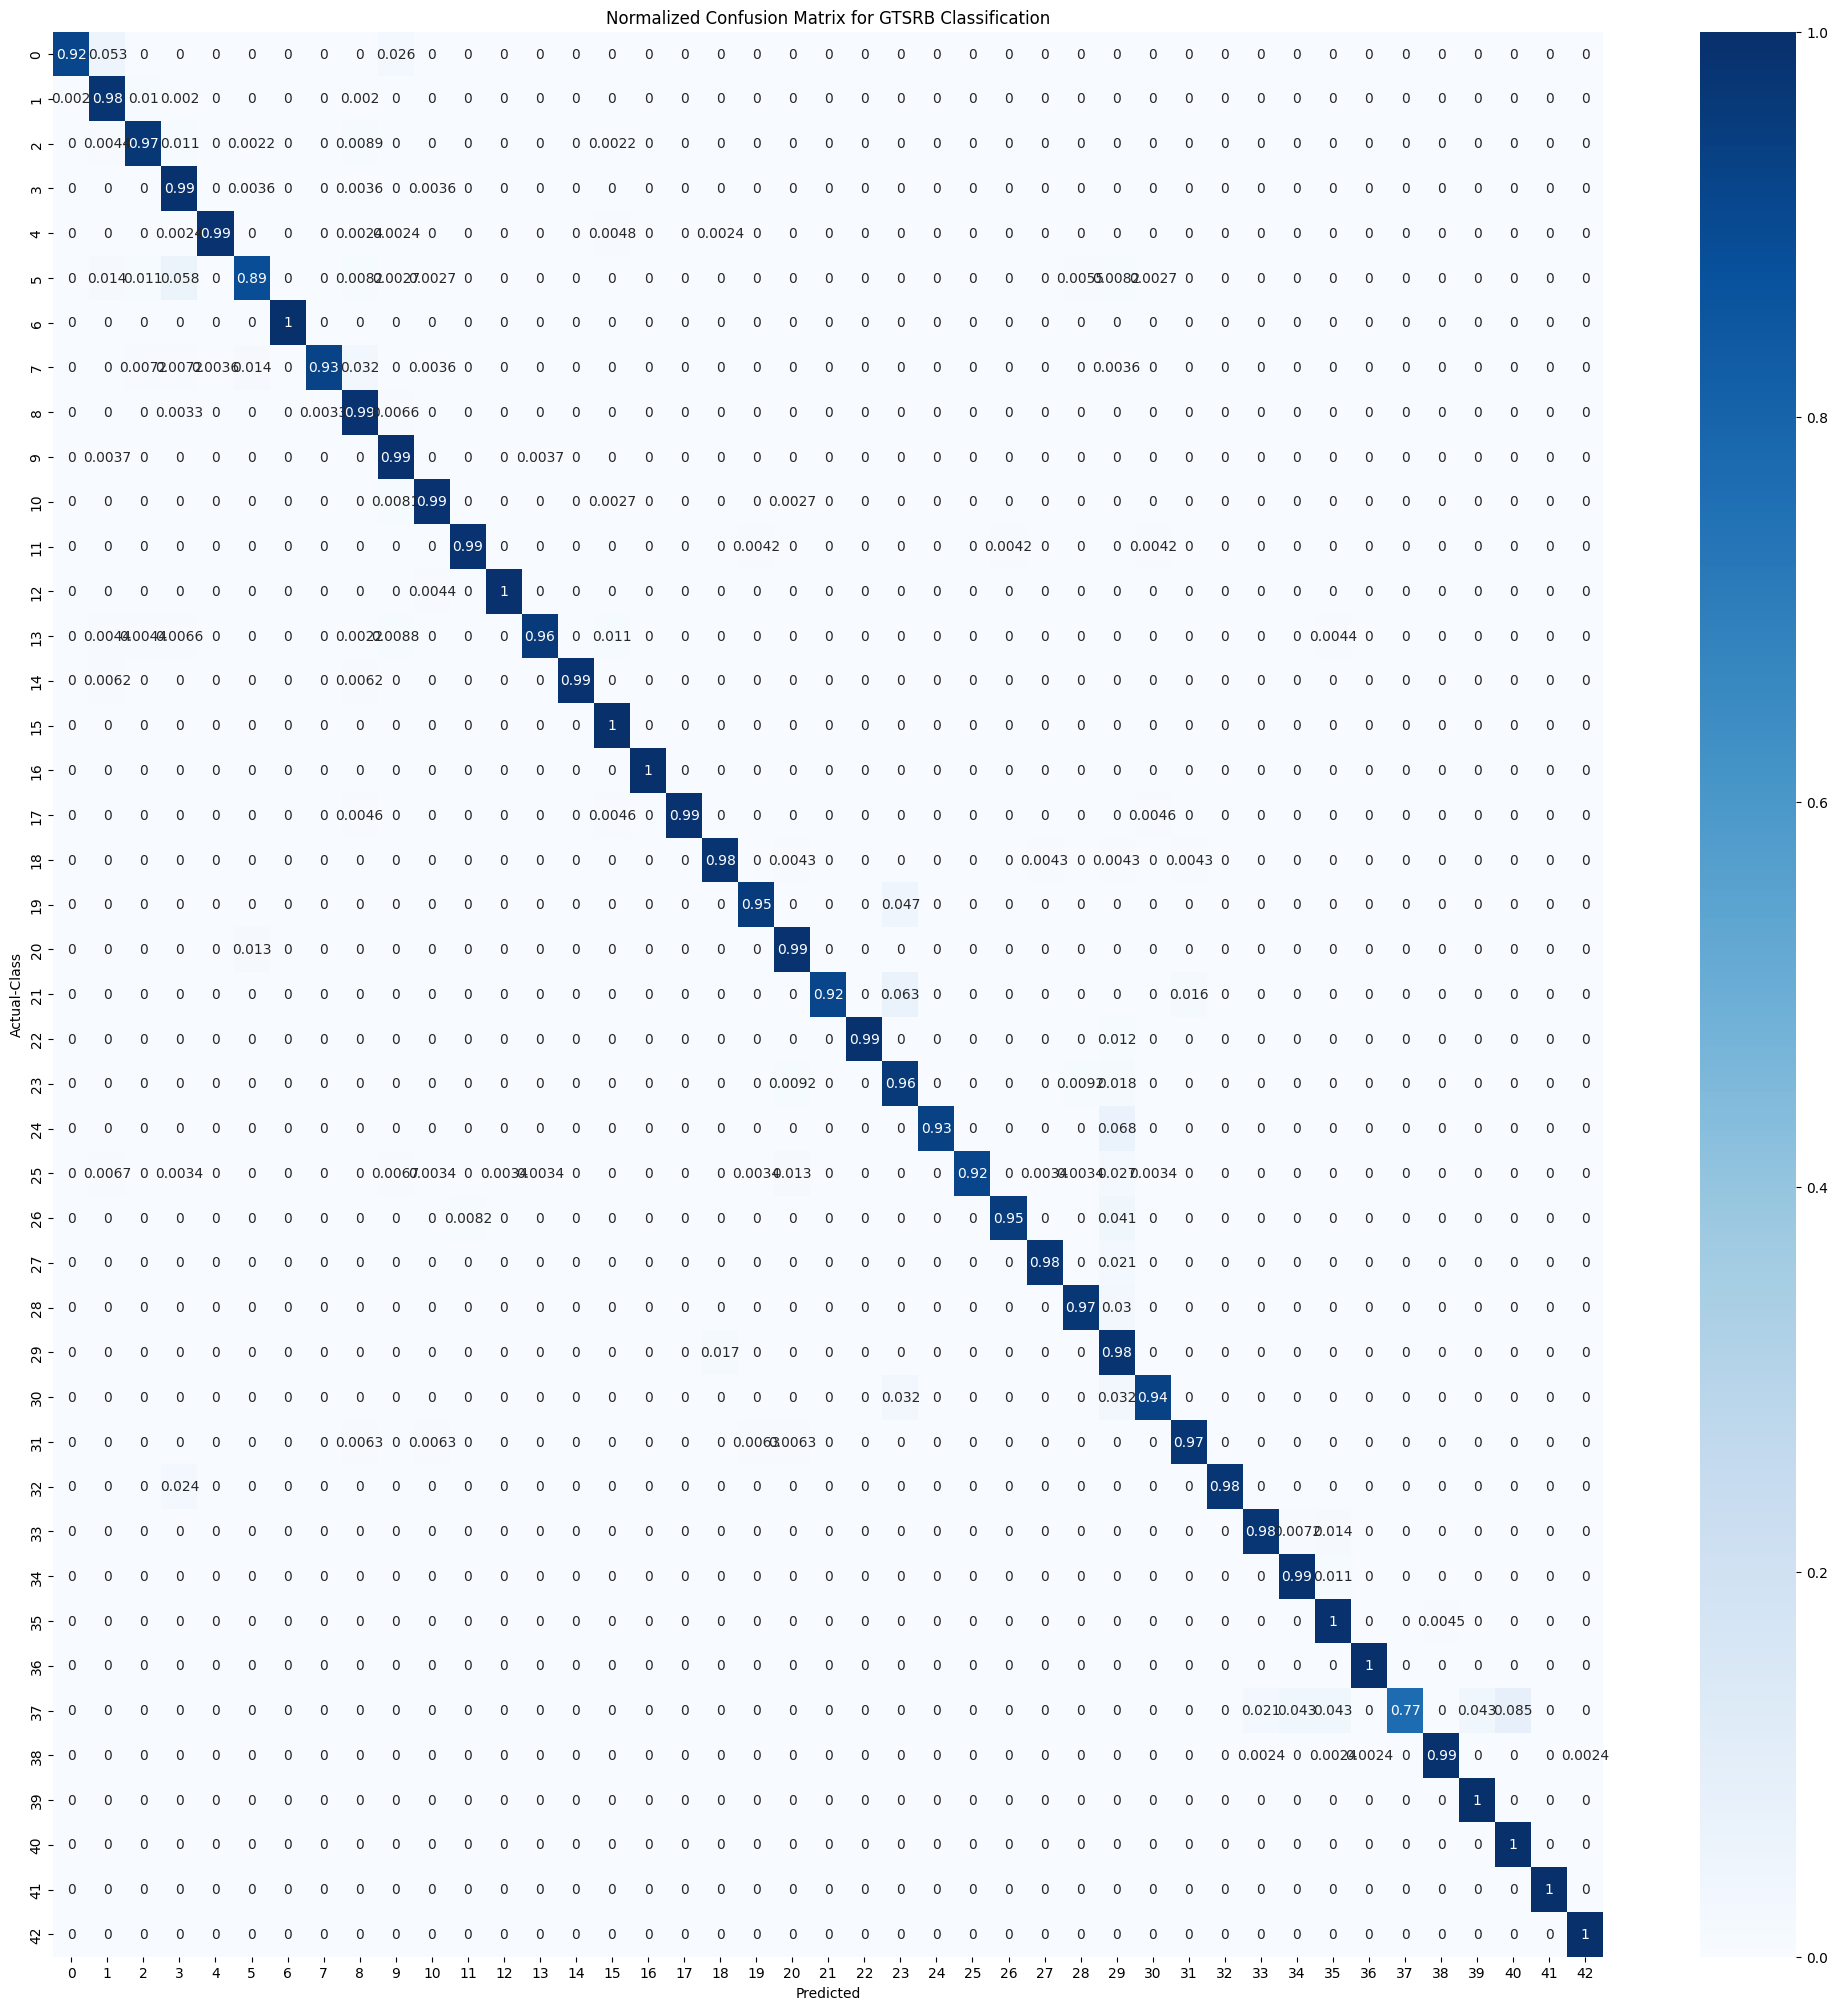

              precision    recall  f1-score   support

     Class 0       0.97      0.92      0.95        38
     Class 1       0.97      0.98      0.98       496
     Class 2       0.97      0.97      0.97       450
     Class 3       0.88      0.99      0.93       280
     Class 4       1.00      0.99      0.99       418
     Class 5       0.98      0.89      0.93       364
     Class 6       1.00      1.00      1.00        59
     Class 7       1.00      0.93      0.96       278
     Class 8       0.93      0.99      0.96       301
     Class 9       0.95      0.99      0.97       268
    Class 10       0.98      0.99      0.98       370
    Class 11       1.00      0.99      0.99       236
    Class 12       1.00      1.00      1.00       450
    Class 13       1.00      0.96      0.98       452
    Class 14       1.00      0.99      0.99       162
    Class 15       0.92      1.00      0.96       120
    Class 16       1.00      1.00      1.00        90
    Class 17       1.00    

In [18]:
# Confusion Matrix visualisieren
plt.figure(figsize=(25, 25))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', xticklabels=range(43), yticklabels=range(43)) #, fmt='.2%'
plt.xlabel('Predicted')
plt.ylabel('Actual-Class')
plt.title('Normalized Confusion Matrix for GTSRB Classification')
plt.show()

# Zusätzliche Metriken ausgeben
print(classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(43)]))

## SVM als Klassifizierer

neben den CNN ist ein ebenso weit verbreiter Classifier die SVM

In [19]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

Für SVMs werden die Bilder in einem amderen Format benötigt, daher werden diese hier erneut formatiert.

In [20]:
images = format_imgs(trainImages)
labels = trainLabels

# Überprüfen, ob alle Bilder die gleiche Größe haben
print("Bildgröße:", np.array(images).shape)  # Sollte (Anzahl_Bilder, 32, 32) sein

# Daten normalisieren und in das richtige Format bringen
# Bilder werden auf einen Bereich von 0 bis 1 normalisiert, indem sie durch 255 geteilt werden
# Die Bilder werden in einen zweidimensionalen Vektor umgeformt
X = np.array(images).reshape(len(images), -1) / 255.0
y = np.array(labels)


# Daten in Trainings- und Testdaten aufteilen
# 80% der Daten werden für das Training verwendet, 20% für das Testen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Bildgröße: (39209, 32, 32, 3)


Ein Support Vector Machine (SVM) Modell mit linearem Kernel wird erstellt. Der Parameter C=1.0 reguliert den Einfluss von Fehlklassifikationen.

In [21]:
# SVM Modell erstellen
# Wir erstellen ein Support Vector Machine (SVM) Modell mit einem linearen Kernel
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

In [22]:
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [23]:
# Vorhersagen auf den Testdaten
y_pred = svm_model.predict(X_test)

# Genauigkeit berechnen
accuracy = accuracy_score(y_test, y_pred)
print(f'Genauigkeit: {accuracy * 100:.2f}%')

# Klassifikationsbericht anzeigen
print(classification_report(y_test, y_pred))

Genauigkeit: 13.22%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.18      0.33      0.24       496
          10       0.07      0.81      0.14       370
          11       0.00      0.00      0.00       236
          12       0.88      0.03      0.06       450
          13       0.39      0.30      0.34       452
          14       0.00      0.00      0.00       162
          15       0.00      0.00      0.00       120
          16       0.00      0.00      0.00        90
          17       0.00      0.00      0.00       219
          18       0.00      0.00      0.00       231
          19       0.00      0.00      0.00        43
           2       0.12      0.46      0.20       450
          20       0.00      0.00      0.00        78
          21       0.00      0.00      0.00        63
          22       0.00      0.00      0.00        86
          23       0.00      0.00      0.00       109
       

c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Vergleich SVM vs CNN

Um das trainierte CNN und die SVM zu vergleichen und zu beurteilen, welches Modell besser für die Klassifizierung von Straßenschildern geeignet ist, gehen wir folgendermaßen vor:

1. **Ergebnisse des CNN-Modells zusammenfassen:**
   - Genauigkeit (Accuracy)
   - Precision, Recall und F1-Score
   - Visualisierung der Trainingsgeschichte (Accuracy und Loss)
   - Confusion Matrix

2. **Ergebnisse des SVM-Modells zusammenfassen:**
   - Genauigkeit (Accuracy)
   - Precision, Recall und F1-Score
   - Confusion Matrix

3. **Vergleich und Beurteilung der beiden Modelle:**

### Ergebnisse des CNN-Modells
Angenommen, das CNN wurde bereits wie folgt trainiert und evaluiert:

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9701 - loss: 0.1300
CNN Validation accuracy: 0.9718183875083923
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.95        38
           1       0.97      0.98      0.98       496
           2       0.97      0.97      0.97       450
           3       0.88      0.99      0.93       280
           4       1.00      0.99      0.99       418
           5       0.98      0.89      0.93       364
           6       1.00      1.00      1.00        59
           7       1.00      0.93      0.96       278
           8       0.93      0.99      0.96       301
           9       0.95      0.99      0.97       268
          10       0.98      0.99      0.98       370
          11       1.00      0.99      0.99       236
          12       1.00      1.00      1.00       450
          13       1.00      0.96      0.98       452
          14       1.00      

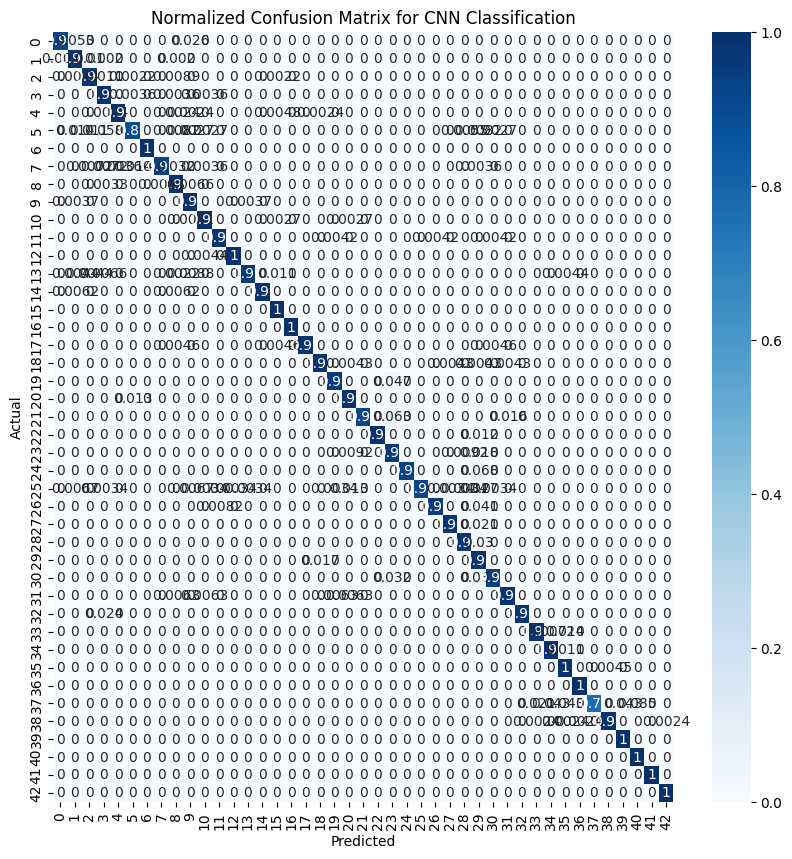

In [24]:
# Evaluation des CNN-Modells
val_loss, val_acc = model.evaluate(img_test, labels_test)
print(f'CNN Validation accuracy: {val_acc}')

# Klassifikationsbericht für CNN
y_pred_cnn = model.predict(img_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_cnn = np.argmax(labels_test, axis=1)
print(classification_report(y_true_cnn, y_pred_classes_cnn))

# Confusion Matrix für CNN
conf_matrix_cnn = confusion_matrix(y_true_cnn, y_pred_classes_cnn)
conf_matrix_normalized_cnn = conf_matrix_cnn.astype('float') / conf_matrix_cnn.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_normalized_cnn, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix for CNN Classification')
plt.show()

### Ergebnisse des SVM-Modells
Das SVM-Modell wurde bereits wie folgt trainiert und evaluiert:

SVM Validation accuracy: 13.22%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.18      0.33      0.24       496
          10       0.07      0.81      0.14       370
          11       0.00      0.00      0.00       236
          12       0.88      0.03      0.06       450
          13       0.39      0.30      0.34       452
          14       0.00      0.00      0.00       162
          15       0.00      0.00      0.00       120
          16       0.00      0.00      0.00        90
          17       0.00      0.00      0.00       219
          18       0.00      0.00      0.00       231
          19       0.00      0.00      0.00        43
           2       0.12      0.46      0.20       450
          20       0.00      0.00      0.00        78
          21       0.00      0.00      0.00        63
          22       0.00      0.00      0.00        86
          23       0.00      0.00      0.00      

c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

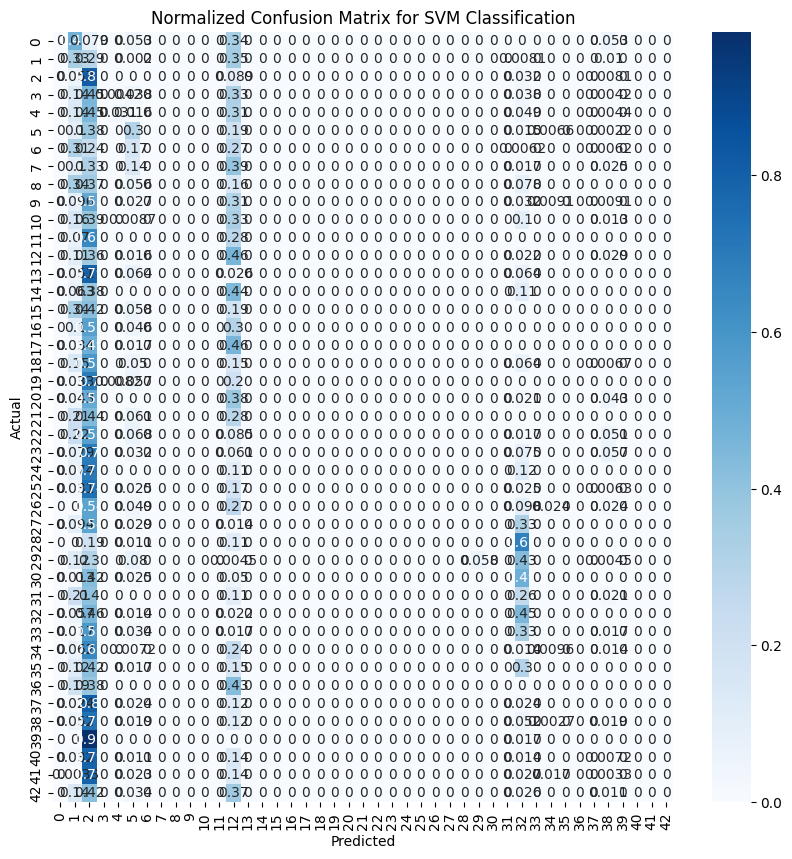

In [25]:
# Evaluation des SVM-Modells
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Validation accuracy: {accuracy * 100:.2f}%')

# Klassifikationsbericht für SVM
print(classification_report(y_test, y_pred))

# Confusion Matrix für SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred)
conf_matrix_normalized_svm = conf_matrix_svm.astype('float') / conf_matrix_svm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_normalized_svm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix for SVM Classification')
plt.show()

### Vergleich und Beurteilung

...